In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader , Subset, random_split
from torch.utils.tensorboard import SummaryWriter

In [2]:
import sys
import re
import numpy as np
import pandas as pd
import random

In [38]:
from itertools import chain

In [39]:
import matplotlib.pyplot as plt

In [40]:
import import_ipynb
import preprocessor

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
from nltk.tokenize import word_tokenize

from konlpy.tag import *

In [11]:
mecab = Mecab()

## Data

In [12]:
dir_path = '../../Data/'
data = pd.read_excel(dir_path + '한국어_대화체_번역.xlsx' , engine='openpyxl')

In [13]:
data[['원문','번역문']].head()

,원문,번역문
0,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...


## Preprocessing

In [14]:
en_data = data['번역문']
kor_data = data['원문']

In [16]:
en_vs = preprocessor.VocabSet(word_tokenize, th=3)
en_tokens = en_vs.tokens(en_data)
en_encoder = preprocessor.Encoder(en_data, word_tokenize, en_tokens)

100%|██████████| 100000/100000 [00:13<00:00, 7288.73it/s]


In [17]:
en_encoded = en_encoder.encode()

100%|██████████| 100000/100000 [00:14<00:00, 7116.53it/s]


In [18]:
kor_vs = preprocessor.VocabSet(mecab.morphs, th=3)
kor_tokens = kor_vs.tokens(kor_data)
kor_encoder = preprocessor.Encoder(kor_data, mecab.morphs, kor_tokens)

100%|██████████| 100000/100000 [00:08<00:00, 12279.33it/s]


In [19]:
kor_encoded = kor_encoder.encode()

100%|██████████| 100000/100000 [00:08<00:00, 11658.67it/s]


In [20]:
en_len = [len(en) for en in en_encoded]
kor_len = [len(kor) for kor in kor_encoded]

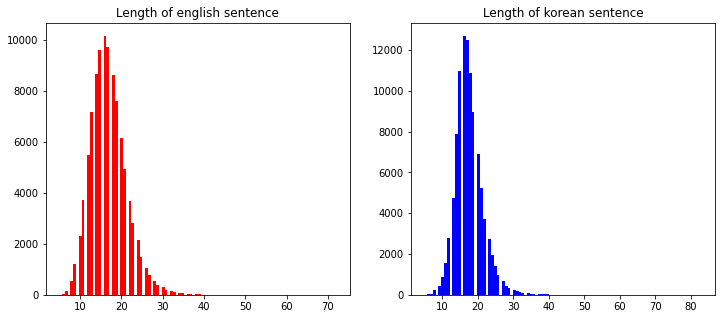

In [21]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

axes[0].set_title('Length of english sentence')
axes[0].hist(en_len, bins=100, color='r')

axes[1].set_title('Length of korean sentence')
axes[1].hist(kor_len, bins=100, color='b')

plt.show()

## Dataset & DataLoader

In [22]:
class EncoderDecoderDataset(Dataset) :

    def __init__(self, en_list, de_list, sen_size, val_ratio=0.1) :
        super(EncoderDecoderDataset , self).__init__()
        self.en_in = pad_sequences(en_list, maxlen=sen_size, padding='post')
        
        de_array = pad_sequences(de_list, maxlen=sen_size+1, padding='post')
        self.de_in = de_array[:,:-1]
        self.de_out = de_array[:,1:]
        
        self.val_ratio = val_ratio

    def __len__(self) :
        return len(self.en_in)

    def __getitem__(self , idx) :
        en_in_idx = self.en_in[idx]
        de_in_idx = self.de_in[idx]
        de_out_idx = self.de_out[idx]
        
        return {'encoder_in' : en_in_idx, 'decoder_in' : de_in_idx, 'decoder_out' : de_out_idx}
    
    def split_dataset(self) :
        n_val = int(len(self) * self.val_ratio)
        n_train = len(self) - n_val
        train_set, val_set = random_split(self, [n_train, n_val])
        
        return train_set, val_set

In [23]:
max_len = 25

dataset = EncoderDecoderDataset(kor_encoded, en_encoded, max_len)

In [24]:
train_set, val_set = dataset.split_dataset()

In [25]:
batch_size = 60

train_loader = DataLoader(train_set ,
                          batch_size = batch_size,
                          num_workers = 4,
                          shuffle = True,
                          drop_last = True)

val_loader = DataLoader(val_set ,
                        batch_size = 100,
                        num_workers = 4,
                        shuffle = False,
                        drop_last = True)

## Device & Seed

In [26]:
use_cuda = torch.cuda.is_available()
random.seed(20210906)
torch.cuda.manual_seed_all(20210906)
device = torch.device("cuda" if use_cuda else "cpu") 

## Model

In [27]:
class PaddingMask(nn.Module) :

    def __init__(self, sen_size) :
        super(PaddingMask , self).__init__() 
        self.sen_size = sen_size
    
    def forward(self, in_tensor) :
        batch_size = in_tensor.shape[0]
        # mask tensor which element is 0.0
        flag_tensor = torch.where(in_tensor == 0.0 , 1.0 , 0.0)
        # shape : (batch_size, 1, 1, sen_size)
        flag_tensor = torch.reshape(flag_tensor , (batch_size, 1, 1, self.sen_size)) 
        
        return flag_tensor

In [28]:
class LookAheadMask(nn.Module) :

    def __init__(self, sen_size, cuda_flag) :
        super(LookAheadMask, self).__init__() 
        self.sen_size = sen_size
        self.mask_tensor = self.get_mask(sen_size).cuda() if cuda_flag else self.get_mask(sen_size)

    def get_mask(self, sen_size) :
        # masking tensor
        mask_array = 1 - np.tril(np.ones((sen_size,sen_size)) , 0)
        mask_tensor = torch.tensor(mask_array , dtype = torch.float32 , requires_grad=False)
        mask_tensor = mask_tensor.unsqueeze(0) # shape : (1, sen_size, sen_size)

        return mask_tensor
    
    def forward(self, in_tensor) :
        mask_tensor = torch.maximum(in_tensor, self.mask_tensor)

        return mask_tensor

In [59]:
class PositionalEncoding(nn.Module) :

    def __init__(self, pos_len, d_model, cuda_flag) :
        super(PositionalEncoding , self).__init__()
        self.pos_len = pos_len
        self.d_model = d_model

        # w : weight
        # pe : Encoding tensor
        if cuda_flag == True :
            self.w = torch.sqrt(torch.tensor(d_model, dtype=torch.float32, requires_grad=False)).cuda()
            self.pe = self.get_embedding(pos_len, d_model).cuda()

        else :
            self.w = torch.sqrt(torch.tensor(d_model, dtype=torch.float32, requires_grad=False))
            self.pe = self.get_embedding(pos_len, d_model)

    # Embedding tensor : (batch_size, sen_size, embedding_dimension)
    # Making Encoding tensor (1, sen_size, embedding_dimension)
    def get_embedding(self, pos_len, d_model) :
        pos_vec = torch.arange(pos_len).float()
        pos_vec = pos_vec.unsqueeze(1)

        i_vec = torch.arange(d_model).float() / 2
        i_vec = torch.floor(i_vec) * 2
        i_vec = i_vec.unsqueeze(0) / d_model
        i_vec = 1 / torch.pow(1e+4 , i_vec)

        em = torch.matmul(pos_vec, i_vec)
        pe = torch.zeros(pos_len, d_model, requires_grad=False)

        sin_em = torch.sin(em)
        cos_em = torch.cos(em)

        pe[:,::2] = sin_em[:,::2]
        pe[:,1::2] = cos_em[:,1::2]

        pe = pe.unsqueeze(0)

        return pe

    def forward(self, in_tensor) :
        en_tensor = in_tensor * self.w + self.pe
        
        return en_tensor

In [60]:
class MultiHeadAttention(nn.Module) :

    def __init__(self, sen_size,  d_model, num_heads) :
        super(MultiHeadAttention , self).__init__()
        self.sen_size = sen_size # sen_size
        self.d_model = d_model # embedidng_dim
        self.num_heads = num_heads # head_size
        self.depth = int(d_model / num_heads) # embedding_dim / num_heads

        self.q_layer = nn.Linear(d_model , d_model)
        self.k_layer = nn.Linear(d_model , d_model)
        self.v_layer = nn.Linear(d_model , d_model)
        self.o_layer = nn.Linear(d_model , d_model)

        self.scale = torch.sqrt(torch.tensor(self.depth , dtype=torch.float32 , requires_grad=False))
        
        self.init_param()

    def split(self, tensor) :
        tensor = torch.reshape(tensor , (-1 , self.sen_size , self.num_heads , self.depth)) # (batch_size, sen_size, num_heads, depth)
        tensor = torch.transpose(tensor , 2 , 1) # batch_size, num_heads, sen_size, depth)

        return tensor

    def merge(self, tensor) :
        tensor = torch.transpose(tensor , 2 , 1) # (batch_size, sen_size, num_heads, depth)
        tensor = torch.reshape(tensor , (-1 , self.sen_size , self.d_model)) # (batch_size , sen_size , embedding_dim)

        return tensor

    def scaled_dot_production(self, q_tensor, k_tensor, v_tensor, m_tensor) :
        q_tensor = self.split(q_tensor)
        k_tensor = self.split(k_tensor)
        v_tensor = self.split(v_tensor)
        
        k_tensor_T = torch.transpose(k_tensor , 3 , 2) # (batch_size, num_heads, depth, sen_size)

        qk_tensor = torch.matmul(q_tensor , k_tensor_T) # (batch_size, num_heads, sen_size, sen_size)
        qk_tensor /= self.scale

        # pad mask tensor shape : (batch_size, 1, 1, sen_size)
        # lookahead mask tensor shape : (batch_size, 1, sen_size, sen_size)
        if m_tensor != None :
            qk_tensor -= (m_tensor * 1e+6)

        qk_tensor = F.softmax(qk_tensor , dim = -1)
        att = torch.matmul(qk_tensor , v_tensor) # (batch_size, num_heads, sen_size, depth)

        return att

    # Xavier Initialization
    def init_param(self) :
        for m in self.modules() :
            if isinstance(m,nn.Linear) :
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, q_in, k_in, v_in, m_in) :
        q_tensor = self.q_layer(q_in)
        k_tensor = self.k_layer(k_in)
        v_tensor = self.v_layer(v_in)

        att_tensor = self.scaled_dot_production(q_tensor , k_tensor , v_tensor , m_in)
        att_tensor = self.merge(att_tensor)

        o_tensor = self.o_layer(att_tensor)

        return o_tensor


In [61]:
class FeedForward(nn.Module) :

    def __init__(self, hidden_size, d_model) :
        super(FeedForward , self).__init__()
        self.hidden_size = hidden_size
        self.d_model = d_model
        
        # relu activation and input, output dim are same
        self.ff = nn.Sequential(nn.Linear(d_model , hidden_size), 
                                nn.ReLU(),
                                nn.Linear(hidden_size , d_model))
        self.init_param()
                
    # He Initialization
    def init_param(self) :
        gain = 2 ** (1/2)
        for m in self.modules() :
            if isinstance(m , nn.Linear) :
                nn.init.kaiming_normal_(m.weight , gain)
                nn.init.zeros_(m.bias)

    def forward(self , in_tensor) :
        o_tensor = self.ff(in_tensor)

        return o_tensor


In [62]:
class TransformerEncoder(nn.Module) :

    def __init__(self, layer_size, sen_size, v_size, d_model, num_heads, hidden_size, 
                 drop_rate, norm_rate, cuda_flag) :
        super(TransformerEncoder , self).__init__()
        self.layer_size = layer_size
        self.sen_size = sen_size
        self.v_size = v_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.drop_rate = drop_rate
        self.norm_rate = norm_rate

        self.em = nn.Embedding(num_embeddings=v_size, embedding_dim=d_model, padding_idx=0) # embedding
        self.pos = PositionalEncoding(sen_size, d_model, cuda_flag) # positional encoding
        self.pad = PaddingMask(sen_size) # masking
        
        self.mha_layer = nn.ModuleList()
        self.ff_layer = nn.ModuleList()

        self.drop_layer = nn.Dropout(drop_rate)
        self.norm_layer = nn.LayerNorm(d_model , eps=norm_rate)

        for i in range(layer_size) :
            self.mha_layer.append(MultiHeadAttention(sen_size , d_model , num_heads))
            self.ff_layer.append(FeedForward(hidden_size , d_model))

        self.init_param()
            
    def init_param(self) :
        nn.init.normal_(self.em.weight, mean=0.0, std=0.1)
            
    def forward_block(self, i, in_tensor, m_tensor) :
        mha_tensor = self.mha_layer[i](in_tensor , in_tensor , in_tensor , m_tensor)
        mha_tensor = self.drop_layer(mha_tensor)
        h_tensor = self.norm_layer(in_tensor + mha_tensor)

        ff_tensor = self.ff_layer[i](h_tensor)
        ff_tensor = self.drop_layer(ff_tensor)
        o_tensor = self.norm_layer(h_tensor + ff_tensor)

        return o_tensor

    def forward(self, in_tensor) :
        pad_mask = self.pad(in_tensor)
        
        em_tensor = self.em(in_tensor)
        en_tensor = self.pos(em_tensor)
        
        tensor_ptr = en_tensor
        for i in range(self.layer_size) :
            tensor_ptr = self.forward_block(i, tensor_ptr, pad_mask)
        
        return tensor_ptr


In [93]:
class TransformerDecoder(nn.Module) :

    def __init__(self, layer_size, sen_size, v_size, d_model, num_heads, hidden_size, 
                 drop_rate, norm_rate, cuda_flag) :
        super(TransformerDecoder , self).__init__()
        self.layer_size = layer_size
        self.sen_size = sen_size
        self.v_size = v_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.drop_rate = drop_rate
        self.norm_rate = norm_rate
        
        self.em = nn.Embedding(num_embeddings=v_size, embedding_dim=d_model, padding_idx=0) # embedding
        self.pos = PositionalEncoding(sen_size, d_model, cuda_flag) # positional encoding
        self.pad = PaddingMask(sen_size) # padding masking
        self.lookahead = LookAheadMask(sen_size , cuda_flag) # lookahead masking
        
        self.masked_mha_layer = nn.ModuleList()
        self.mha_layer = nn.ModuleList()
        self.ff_layer = nn.ModuleList()

        self.drop_layer = nn.Dropout(drop_rate)
        self.norm_layer = nn.LayerNorm(d_model , eps=norm_rate)
        
        self.o_layer = nn.Linear(d_model, v_size)

        for i in range(layer_size) :
            self.masked_mha_layer.append(MultiHeadAttention(sen_size , d_model , num_heads))
            self.mha_layer.append(MultiHeadAttention(sen_size , d_model , num_heads))
            self.ff_layer.append(FeedForward(hidden_size , d_model))
    
        self.init_param()
        
    def init_param(self) :
        nn.init.normal_(self.em.weight, mean=0.0, std=0.1)
        
        nn.init.xavier_normal_(self.o_layer.weight, gain=1.0)
        nn.init.zeros_(self.o_layer.bias)
            
    def forward_block(self, i, in_tensor, en_out_tensor, padding_mask, lookahead_mask) :
        # query : in_tensor
        # key : in_tensor 
        # value : in_tensor 
        # mask ; look ahead mask
        m_mha_tensor = self.masked_mha_layer[i](in_tensor , in_tensor , in_tensor , lookahead_mask)
        m_mha_tensor = self.drop_layer(m_mha_tensor)
        h_tensor = self.norm_layer(in_tensor + m_mha_tensor)

        # query : output of masked multihead attention
        # key : encoder output , 
        # value : encoder output , 
        # mask ; pad_tensor of decoder input
        mha_tensor = self.mha_layer[i](h_tensor, en_out_tensor, en_out_tensor, padding_mask)
        mha_tensor = self.drop_layer(mha_tensor)
        a_tensor = self.norm_layer(h_tensor+mha_tensor)

        ff_tensor = self.ff_layer[i](a_tensor)
        ff_tensor = self.drop_layer(ff_tensor)
        o_tensor = self.norm_layer(a_tensor+ff_tensor)

        return o_tensor

    def forward(self, in_tensor, en_out_tensor) :
        pad_mask = self.pad(in_tensor)
        lookahead_mask = self.lookahead(pad_mask)
        
        em_tensor = self.em(in_tensor)
        de_tensor = self.pos(em_tensor)
        
        tensor_ptr = de_tensor
        for i in range(self.layer_size) :
            tensor_ptr = self.forward_block(i, tensor_ptr, en_out_tensor, pad_mask, lookahead_mask)
        o_tensor = self.o_layer(tensor_ptr)
        
        return o_tensor


## Model Parameter

In [94]:
en_v_size = en_encoder.get_size()
kor_v_size = kor_encoder.get_size()

layer_size = 6
sen_size = max_len
d_model = 512
num_heads = 8
h_size = 2048
drop_rate = 1e-1
norm_rate = 1e-6

In [95]:
encoder = TransformerEncoder(layer_size, sen_size, kor_v_size, 
                             d_model, num_heads, h_size, drop_rate, norm_rate, use_cuda).to(device)

decoder = TransformerDecoder(layer_size, sen_size, en_v_size, 
                             d_model, num_heads, h_size, drop_rate, norm_rate, use_cuda).to(device)

## Optimizer

In [96]:
dumb_lr = 1e-4 # no meaning

epoch_size = int(100000 / len(train_loader))
warmup_steps = 4000

In [97]:
def schedule_fn(epoch, d_model, dumb_lr) :
    step_num = epoch + 1
    val1 = d_model ** (-0.5)
    
    arg1 = step_num ** (-0.5)
    arg2 = (warmup_steps ** (-1.5)) * step_num
    
    val2 = min(arg1 , arg2) 
    return (val1 * val2) / dumb_lr

In [98]:
tf_param = chain(encoder.parameters(), decoder.parameters())

optimizer = optim.Adam(tf_param, lr=dumb_lr, betas=(0.9,0.98), eps=1e-9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, 
                                        lr_lambda = lambda epoch: schedule_fn(epoch, d_model, dumb_lr))

## Acc & Loss Function

In [99]:
def acc_fn(y_output , y_label) :
    
    y_arg = torch.argmax(y_output, dim=-1)
    y_acc = (y_arg == y_label).float()

    y_acc = torch.mean(y_acc)
    
    return y_acc

In [100]:
loss_fn = nn.CrossEntropyLoss()

## Logging

In [101]:
writer = SummaryWriter('./Log/runs/transformer/')

## Training

In [102]:
min_loss = np.inf
stop_count = 0
log_count = 0

In [103]:
def progressLearning(value, endvalue, loss , acc , bar_length=50):
    percent = float(value + 1) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rPercent: [{0}] {1}/{2} \t Loss : {3:.3f} , Acc : {4:.3f}".format(arrow + spaces, value+1 , endvalue , loss , acc))
    sys.stdout.flush()

In [110]:
def evaluate(encoder, decoder, test_loader) :
    with torch.no_grad() :
        encoder.eval()
        decoder.eval()
        loss_eval = 0.0
        acc_eval = 0.0
        for data in test_loader :
            en_in = data['encoder_in'].long().to(device)
            de_in = data['decoder_in'].long().to(device)
            de_label = data['decoder_out'].long().to(device)
            
            de_label = data['decoder_out'].long().to(device)
            de_label = de_label.view([-1,])
            
            en_output = encoder(en_in)
            de_output = decoder(de_in, en_output)
            de_output = de_output.view([-1, en_v_size])

            loss_eval += loss_fn(de_output , de_label)
            acc_eval += acc_fn(de_output , de_label)

        encoder.train()
        decoder.train()

        loss_eval /= len(test_loader)
        acc_eval /= len(test_loader)
        
    return loss_eval , acc_eval  

In [ ]:
for epoch in range(epoch_size) :
    idx = 0
    lr_idx = optimizer.param_groups[0]['lr']
    print('Epoch : %d \t Learning Rate : %e' %(epoch , lr_idx))

    for data in train_loader :
        en_in = data['encoder_in'].long().to(device)
        de_in = data['decoder_in'].long().to(device)
        
        de_label = data['decoder_out'].long().to(device)
        de_label = de_label.view([-1,])

        optimizer.zero_grad()
        
        en_output = encoder(en_in)
        de_output = decoder(de_in, en_output)
        de_output = de_output.view([-1, en_v_size])

        loss = loss_fn(de_output , de_label)
        acc = acc_fn(de_output , de_label)

        loss.backward()
        optimizer.step()
        
        progressLearning(idx, len(train_loader), loss.item(), acc.item())

        if (idx + 1) % 10 == 0 :
            writer.add_scalar('train/loss' , loss.item() , log_count)
            writer.add_scalar('train/acc' , acc.item() , log_count)
            log_count += 1
        
        idx += 1

    val_loss, val_acc = evaluate(encoder, decoder, val_loader)
        
    writer.add_scalar('test/loss' , val_loss.item() , epoch)
    writer.add_scalar('test/acc' , val_acc.item() , epoch)
    
    if val_loss < min_loss :
        min_loss = val_loss
        torch.save({'epoch' : (epoch) ,  
                    'encoder_state_dict' : encoder.state_dict() , 
                    'decoder_state_dict' : decoder.state_dict() , 
                    'loss' : val_loss.item() , 
                    'acc' : val_acc.item()} , 
                    f'./Model/checkpoint_transformer.pt')        
        stop_count = 0 
    
    else :
        stop_count += 1
        if stop_count >= 5 :      
            print('\nTraining Early Stopped')
            break

    scheduler.step()
    print('\nVal Loss : %.3f \t Val Accuracy : %.3f\n' %(val_loss, val_acc))


Epoch : 0 	 Learning Rate : 1.746928e-07
Percent: [------------------------------------------------->] 1500/1500 	 Loss : 6.397 , Acc : 0.371
Val Loss : 6.363 	 Val Accuracy : 0.362

Epoch : 1 	 Learning Rate : 3.493856e-07
Percent: [------------------------------------------------->] 1500/1500 	 Loss : 5.964 , Acc : 0.346
Val Loss : 5.761 	 Val Accuracy : 0.362

Epoch : 2 	 Learning Rate : 5.240784e-07
Percent: [------------------->                              ] 593/1500 	 Loss : 5.809 , Acc : 0.338